# Plotting Aesthetics

For the following plots in this notebook, I am going to be using $\href{https://seaborn.pydata.org/}{Seaborn}$. This is a really cool statistical visualization library that makes it pretty easy to "beautify" your standard ```matplotlib``` plots. 

For example, here is a basic plot of some standard functions.

In [1]:
import matplotlib.pylab as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

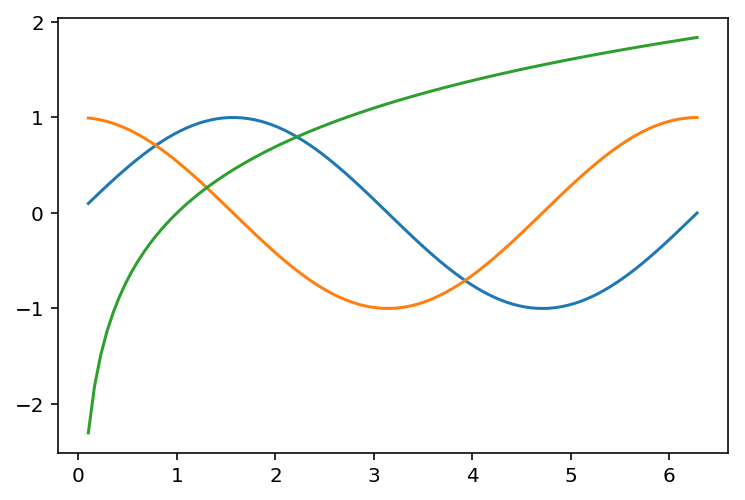

In [2]:
x = np.linspace(0.1, 2*np.pi, 100)
[plt.plot(x, func(x)) for func in (np.sin, np.cos, np.log)]
plt.show()

Now let's try doing the same thing again after importing ```Seaborn```

[[<matplotlib.lines.Line2D at 0x1a1effbb70>],

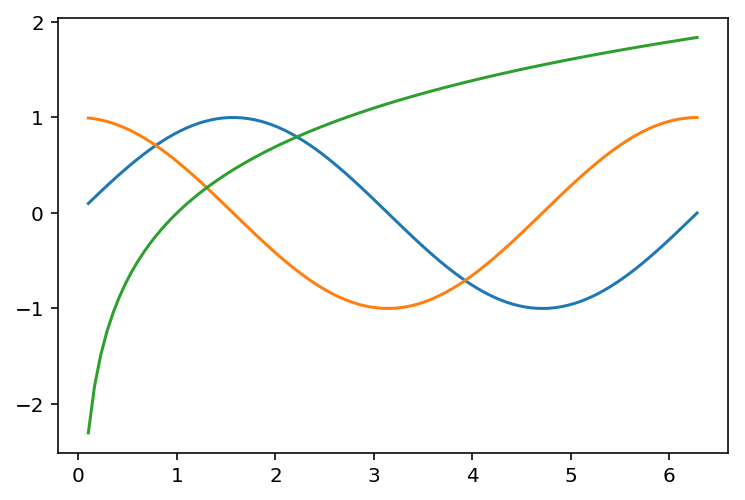

In [3]:
import seaborn as sns
fig = plt.figure()
[plt.plot(x, func(x)) for func in (np.sin, np.cos, np.log)]

This automatically adds a grid to the background, increases the figsize a bit, and adjusts the color palette. Let's try changing the theme and adjusting the color paleete.

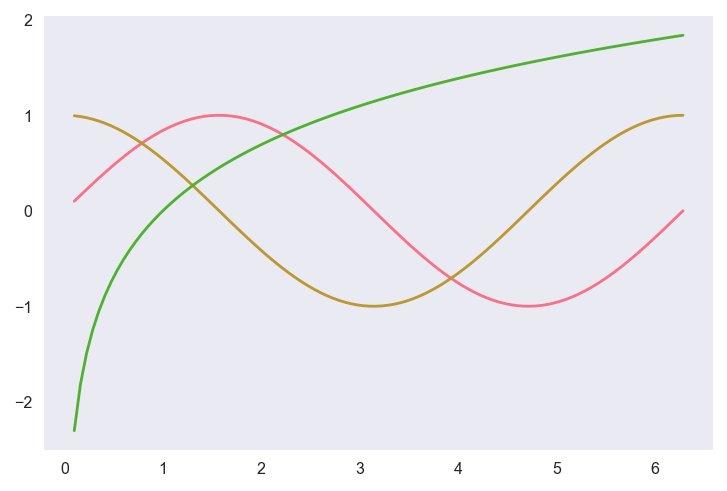

In [4]:
sns.set_context('paper') # paper, talk, poster
sns.set_palette('husl')
sns.set_style('dark')

[plt.plot(x, func(x)) for func in (np.sin, np.cos, np.log)]
plt.show()

Different color palettes can be previewed using ```palplot``` within ```Seaborn```.

```palplot``` can take in an RGB triple like (0,0,1) and displays the corresponding color. In this case, blue.

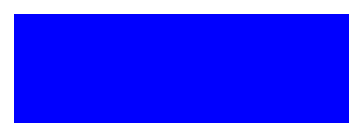

In [5]:
sns.palplot((0,0,1))

```Seaborn``` has a large catalog of different palettes that return triples just like this. Many of the palettes are tailored based on the type of data being visualized, such as sequentially varying data vs. qualitatively varying data, or based on the type of color blindness an audience member may have. A nice overview of the different palettes available can be viewed here. http://seaborn.pydata.org/tutorial/color_palettes.html

I happen to be a fan of xkcd and like using the color code names that were generated in the public survey here https://blog.xkcd.com/2010/05/03/color-survey-results/

It just so happens that ```Seaborn``` has a function ```xkcd_palette``` that converts the user generated names into an RGB triple for use in ```matplotlib```. For example, "barbie pink" would have the following RGB triple:

In [6]:
sns.xkcd_palette(["barbie pink"])

[(0.996078431372549, 0.27450980392156865, 0.6470588235294118)]

This returns a list, but since we are just giving it one color, let's just take the first (and only) element and display it in ```palplot```

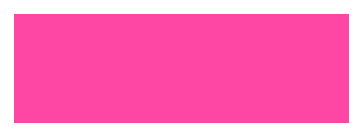

In [7]:
sns.palplot(sns.xkcd_palette(["barbie pink"])[0])

We can now take the contents of ```palplot``` and use this like we would any other color in ```matplotlib```

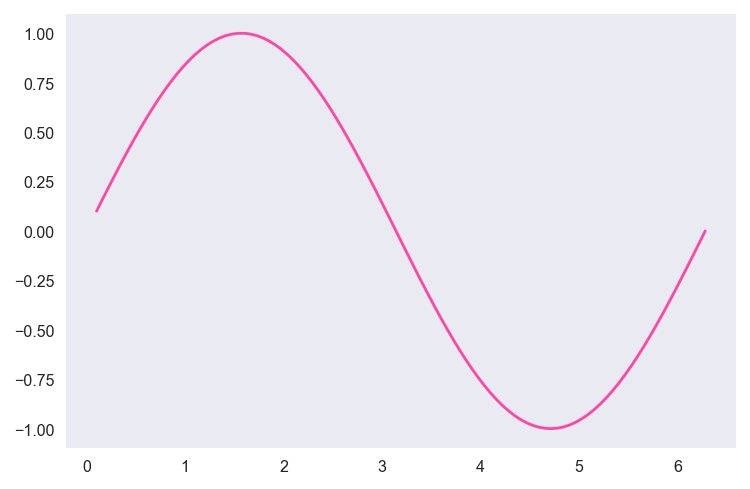

In [8]:
plt.plot(x, np.sin(x), c=sns.xkcd_palette(["barbie pink"])[0])

This would get a bit cumbersome to type every time we wanted to use a cuustom xkcd color, so let's make a convenience function.

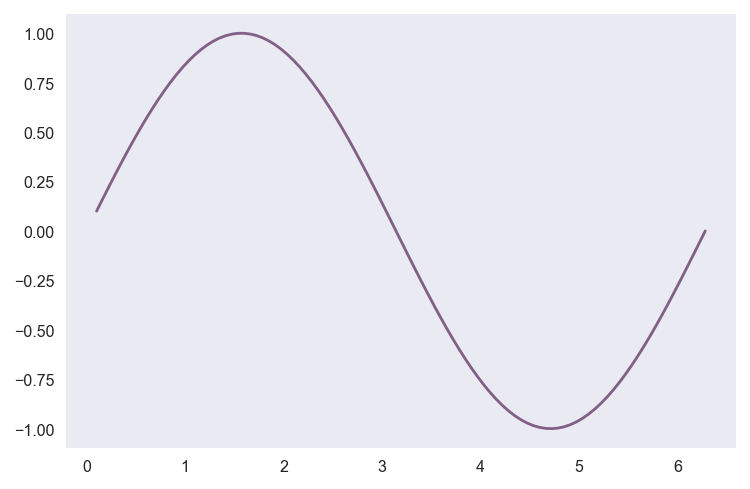

In [9]:
def xkcd(color): return sns.xkcd_palette([color])[0] # convenience function

plt.plot(x, np.sin(x), c=xkcd("dusty purple"))

I happened to be using a dark theme when writing this notebook (just feels nicer on the eyes), so I am also going to be using a custom dark theme for ```Seaborn``` for the rest of this notebook. This part can be skipped, or even modified, to make a plotting theme that looks best to you.

In [37]:
# some plotting preferences for a dark themed notebook
sns.set_style('darkgrid')
dark_style = {'axes.labelcolor': 'white',
              'xtick.color': 'white',
              'ytick.color': 'white',
              'grid.color': 'lightgrey'
            }

sns.set_style(dark_style)

# Newton-Raphson Aside

This is a very useful method for approximating the roots of a well-behaved function (shown in blue). The idea is the following:
* Make a guess next to one of the roots you want 
* Draw the corresponding tangent line (red) at this guess evaluated on the original function (blue) 
* Trace this tangent line to where it intercepts the x-axis
* Make this intercept your new guess
* Rinse and repeat until your latest guess is close enough (your tolerance) to the root you wanted to approximate in the first place

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif">

Numerically, this can be thought of as using the slope and rise of a function at step $n$ to predict its run, taking us to step $n+1$.
\begin{align}
    \text{slope} = \frac{\text{rise}}{\text{run}}\quad\longrightarrow\quad f'(x_n) = \frac{f(x_n)}{x_{n} - x_{n+1}}\quad\longrightarrow\quad
    x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)} \quad .
\end{align}

This is a technique that can be employed when solving for the radial velocity of a star with a planet on an eccentric orbit, as per section 2.3 of your textbook. 

# The Simulation

## Intregration Scheme Aside. Switching gears to Euler.

We talked about using slope and rise to predict run. We are now going to flip this on its head to achieve something else instead: integrating orbits given $$\vec F = m \vec a\quad.$$ 

A popular way of attacking this is to use the Runge Kutta Fourth Order Approximation Scheme (RK4). This is essentialy a slightly more sophisticated version of Euler's Method and the added complexity does not change the overarching theme of using slope and rise to predict run. For this reason, the Euler Method will be discussed in this section to build an intuition for numerical integrators, with the extension to RK4 just touched on lightly. For anyone intersted in the details of this extension, please feel free to come see me during office hours or look at the resources available online for deriving RK4 and its applications.

The motivation behind orbital integration is the following: 

We have some initial conditions, like position and velocity of a planet, and we want to know what kind of orbit this planet will trace out, given that only the force acting on it is gravity. Using the physical insight that the "slope" of position over time is velocity, and the "slope" of velocity over time is acceleration, we can predict, or integrate, how the quantities will change over time. More explicitly, we can use the acceleration supplied by gravity to predict the velocity of our planet, and then use this velocity to predict its position a timestep $\Delta t$ later. This gives us a new position and the whole process starts over again. The cyclical determination of these different quantities is generally termed "orbital integration" and the type of integration scheme used (Euler, RK4, etc.) affects the accuracy of the integrated solution.

Let's focus on the Euler Method. 
<img src="http://jmahaffy.sdsu.edu/courses/f00/math122/lectures/num_method_diff_equations/images/euler_ani.gif">

Note: $h \equiv \Delta t$ in the figure above.

This plot above could represent anything. It could be how one component of the planet's velocity varies over time, or it could be the position of the end of a spring as it slinks back and forth. The point is that we have some solution curve (black) that we want to approximate (red), given that we only know two things:
* where we started $(t_0, y_0)$
* the rate of how where we were changes with time $\left(y'_0 = \frac{y_1 - y_0}{\Delta t}\right)$

The beauty of this is that even though we do not explicity know what $y_1$ is, the fact that we are given $y'_0$ from the initial conditions allows us to bootstrap our way around this. Starting with the definition of slope, we can use the timestep $h = \Delta t$, to find where we will be a timestep later $y_1$:
\begin{align*}
 y_0' = \frac{y_1 - y_0}{\Delta t}\quad\longrightarrow\quad
 y_1 = y_0 + \Delta t\ y_0'\quad.
\end{align*}

Generalizing to any timestep $n$:
\begin{align*}
y_{n+1} = y_n + \Delta t\ y_n'
\end{align*}

Whenever all of the $n+1$ terms are on one side of the equation and the $n$ terms are on the other, we have something called an *explicit numerical method*, which tend to be a bit more straightforward to code. Before hopping in, here is a brief graphical overview of the logic behind RK4.
<img src=./rk4.jpg>

Instead of taking one slope at $t_n$ to inform where $y_{n+1}$ will be, we do something a bit more interesting by using four slopes instead. The first slope is taken at the beginning of the timestep, the next is taken at the half-timestep, the third is also taken at the half-timestep, but using the results from the second slope, and the final slope is taken at the end of the timestep. The results are summarized below:
\begin{align*}
    \dot y = f(t, y),\quad&
    y_{n+1} = y_n + \frac{\Delta t}{6}\left(k_1 + 2k_2 + 2k_3 + k_4\right)\\
    k_1 &= f(t_n, y_n)\\
    k_2 &= f\left(t_n+\frac{\Delta t}{2},\ y_n + \frac{\Delta t}{2}k_1\right)\\
    k_3 &= f\left(t_n+\frac{\Delta t}{2},\ y_n + \frac{\Delta t}{2}k_2\right)\\
    k_4 &= f(t_n + \Delta t, y_n + h k_3)\quad.
\end{align*}


Essentially, four Euler Methods are used in this scheme, and the results are averaged togther with more weight being given to the half-timesteps. Doing this has been found to produce approximations with much smaller errors than the traditional Euler scheme, making this perfect for simulating all types of different orbits!

## Implementing RK4

##### This notebook sets up and runs a simple orbital simulation in 2D using a Runge-Kutta 4th Order integration scheme with adaptive timestepping. The simulation assumes an inertial Cartesian coordinate system with a solar mass object at the origin and massless test particle placed on the negative-x axis (horizontal axis). Here is some brief info of what you can do:

* The initial conditions defined in ```orb_plot ``` can be adjusted in real time under  **Simulation Viewer ** by using the sliders. 
* The position and velocity are tabulated and saved (in cgs) to ```orb.dat``` in the same directory as this notebook and can be viewed in **Taking a look at the data**. A few diagnostic plots are generated from the data as well.
* A movie of the evolution of the orbit can also be made under **Movie Maker**.

In [10]:
from astropy import units as u
from astropy import constants as c
from astropy.io import ascii

In [11]:
# system constants
G    = (1 * c.G).cgs.value
M    = (1 * u.solMass).cgs.value
au   = (1 * u.AU).cgs.value
year = (1 * u.yr).cgs.value

This is where we calculate $\dot y$

In [12]:
def sho_func(t, uin): # calculates derivatives for RK4
    # position and velocity
    r = uin[:2]
    v = uin[2:]
    
    # distance of point mass from each M
    d = np.linalg.norm(0 - r)

    # calulating accelerations
    g = (G*M/d**3) * (0 - r)
    
    derivs = np.ndarray(4)
    derivs[:2] = v
    derivs[2:] = g
    
    return derivs

In [13]:
def sho_RK4(t, u_old, dt): # the "engine" of the numerical integrator
    K1 = sho_func(t, u_old)
    K2 = sho_func(t + dt/2, u_old + K1*dt/2)
    K3 = sho_func(t + dt/2, u_old + K2*dt/2)
    K4 = sho_func(t + dt, u_old + K3*dt) 
    
    u_new = u_old + (dt/6)*(K1 + 2*(K2 + K3) + K4)
    return u_new

## Plotting the Orbit

In [14]:
def orb_plot(x_pos, x_vel, y_vel, T, f): # arguments read in from slider in next section
    # Initial conditions
    n = 0
    t = 0
    x = -x_pos*au
    y = 0 # because of circular symmetry, it doesn't really matter what we put for y
    a0 = np.sqrt(x**2 + y**2)
    v_circ = np.sqrt(G * M / a0)

    vx = x_vel*v_circ
    vy = -y_vel*v_circ
    #T0 = 2*np.pi*np.sqrt(a0**3/(G*M))
    T0  = year

    tmax  =  T*T0
    
    pos_0 = np.array([x, y])
    vel_0 = np.array([vx, vy])

    uold = np.zeros(4)
    uold[:2] = pos_0
    uold[2:] = vel_0

    n_step = []
    time   = []
    x      = []
    y      = []
    vx     = []
    vy     = [] 
    
    fig, ax = plt.subplots(figsize=(6,6))

    #fig.patch.set_alpha(0)
    fig.patch.set_facecolor('#384152')
    ax.patch.set_alpha(0)

    # Integrate orbit
    v0 = np.sqrt(uold[2]**2 + uold[3]**2) # turn on inside for adaptive
    dt = 10**(f) * np.abs(uold[0]) / v0
    #for t in np.arange(0, tmax+dt, dt):
    while (t <= tmax):
        # hold positions and velocities
        n_step.append(n)
        time.append(t)
        x.append(uold[0])
        y.append(uold[1])
        vx.append(uold[2])
        vy.append(uold[3])
        # v0 based on speed at beginning of current timestep
        #v0 = np.sqrt(uold[2]**2 + uold[3]**2) 
        #dt = 10**(f) * np.abs(x[0]) / v0
        unew = sho_RK4(t, uold, dt) # integrate the orbit       

        uold = unew # step forward
        
        n += 1
        t += dt

    # write to file
    ascii.write([n_step, time,x,y,vx,vy], './orb.dat', 
                names=['n', 't (s)', 'x (cm)', 'y (cm)', \
                       'vx (cm/s)', 'vy (cm/s)'], overwrite=True)
    
    # scale position and velocity to physical motivated units
    x = np.array(x) / au
    y = np.array(y) / au
    vx = np.array(vx) / v_circ
    vy = np.array(vy) / v_circ

    ax.set_aspect(aspect='equal')
    lim = 2.5
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    # plot trajectory
    ax.plot(x, y, color=xkcd("amber"))
    
    # overplot circular orbit
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), ls='--', color=xkcd("bright turquoise"))
    
    # plot starting and ending points
    ax.plot(x[0], y[0], color=xkcd("light lavender"), ms=10, marker='X')
    ax.plot(x[-1], y[-1], color=xkcd("fluorescent green"), ms=10, marker='o')
    
    # show the star!
    host = plt.Circle((0, 0), 0.3, fc=xkcd("pinkish orange"))
    ax.add_artist(host)
    
    # graphically show initial velocity vector
    ax.arrow(x[0], y[0], vx[0], vy[0], color='w', head_width=0.05, lw=2)

    fig.tight_layout()
    
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    plt.show() # to update live plot

## Simulation Viewer

The widgets below allow us to dynamically feed different initial conditions to the integrator to see in realtime how it effects the trajectory of Earth. Each of the sliders are created as a ```ipywidgets.FloatSlider``` within  ```ipywidgets```. The sliders are then displayed as an interactive slider within the notebook by sending them to ```ipywidgets.interactive```. The value displayed below each slider widget is sent to ```orb_plot```, the first argument of ```interactive```, and read in as a function argument of ```orb_plot```. The plot of Earth's trajectory is then updated and displayed below based on the user's choices.

In [38]:
import ipywidgets as widgets

box_layout = widgets.Layout(
    display='inline-flex',
    flex_flow='row wrap',
    justify_content='flex-start'
)

items = [
    widgets.FloatSlider(value=1, min=0.5, max=1.5, step=0.01, 
                        description='$-r_x / AU$'),
    widgets.FloatSlider(value=0, min=-2, max=2, step=0.01, 
                        description='$v_x / v_c$'),
    widgets.FloatSlider(value=1, min=-2, max=2, step=0.01, 
                        description='$-v_y / v_c$'),
    widgets.FloatSlider(value=1, min=0.1, max=5, step=0.01, 
                        description='$T$ / $year$'),
    widgets.FloatSlider(value=-1, min=-2, max=2, step=0.01, 
                        description=r'$f,\ dt = 10^f\frac{x_0}{v}$')
        ]

w = widgets.interactive(orb_plot, x_pos=items[0], x_vel=items[1], 
                        y_vel=items[2], T = items[3], f = items[4])

w.layout = box_layout # put the sliders in a box arrangment as opposed to column

# show the widgets
w

interactive(children=(FloatSlider(value=1.0, description='$-r_x / AU$', max=1.5, min=0.5, step=0.01), FloatSlider(value=0.0, description='$v_x / v_c$', max=2.0, min=-2.0, step=0.01), FloatSlider(value=1.0, description='$-v_y / v_c$', max=2.0, min=-2.0, step=0.01), FloatSlider(value=1.0, description='$T$ / $year$', max=5.0, min=0.1, step=0.01), FloatSlider(value=-1.0, description='$f,\\ dt = 10^f\\frac{x_0}{v}$', max=2.0, min=-2.0, step=0.01), Output()), layout=Layout(display='inline-flex', flex_flow='row wrap', justify_content='flex-start'), _dom_classes=('widget-interact',))

Quick summary of the sliders
* $-r_x / 1\ AU$: how far along the x-axis, in AU, the test particle starts. This sets $x_0$.
* $v_x/v_c$: initial x component of the test particle velocity in units of the circular speed $v_c = \sqrt{GM/x_0}$
* $-v_y/v_c$: initial y component of the test particle velocity in units of $v_c$, with down defined as negative.
* $T/1\ year$: How long the simulation runs for, in units of 1 year.
* $f\ \left(dt = 10^f \cdot x_0 / v\right)$: defines the characterisic lengthscale used for cell crossing time in adaptive timestep procedure. $f$ scales the power of ten multiplied by the intitial distance of the test particle from the central mass. $v$ is the total speed of the test particle at the beginning of the current timestep. You can think of larger values of $f$ as making the simulation more "inaccurate" because of the courser timesteps that are made.


Quick summary of the graphical elements
* cyan: the reference circular orbit of the Earth
* orange: current trajectory of the Earth
* white arrow: initial velocity vector
* purple X: starting location
* green circle: final location of the Earth
* dark orange circle: the Sun

# Taking a Look at the Data

From the position and velocity information stored in ```orb.dat``` we can derive different physical quantities like the specific energy and angular momentum of our test particle. Plotting how these quantites vary over time is a nice way to check if our integrator is doing a good job of conserving these quantites. 

Since the test particle is "massless" $(m\to 0)$, the specific energy $E$ and specific angular momentum $L$ is used because it already divides through regular energy and angular momentum by $m$:
$$\begin{aligned} 
    E &= \frac{1}{2}v^2 - \frac{GM}{r} \\ 
    L &= r \times v \quad.
\end{aligned}$$

Typically, adaptive time stepping is a handy way to improve how well the RK4 integrator conserves these quantities. The naive prescription I used just scales the timesteps by how fast the test particle is crossing a given length scale $(\Delta t = 10^f r_0 / v)$. Feel free to play around with the "fudge factor" $f$ on the interactive slider or create your own adaptive time stepping prescription!

In [170]:
t = ascii.read('./orb.dat')

# renaming fields for convenience
n = t['n']
time = t['t (s)']
x = t['x (cm)']
y = t['y (cm)']
vx = t['vx (cm/s)']
vy = t['vy (cm/s)']

t.show_in_notebook()

idx,n,t (s),x (cm),y (cm),vx (cm/s),vy (cm/s)
0,0,0.0,-14959787070000.0,0.0,0.0,-1489234.5914838465
1,1,252326.17059991948,-14940904127607.623,-375614684827.1366,149710.2704437602,-1487353.0288298712
2,2,504652.34119983896,-14884195588298.455,-750277529720.406,299894.58509023895,-1481680.8931458816
3,3,756978.5117997584,-14789481273805.176,-1123022754539.0337,451035.01497410284,-1472134.7822305853
4,4,1009304.6823996779,-14656457482569.209,-1492856156608.4595,603630.0028641728,-1458572.0755596843
5,5,1261630.8529995973,-14484691740588.023,-1858739503268.4873,758203.3664612247,-1440785.2234017602
6,6,1513957.0235995168,-14273615157513.746,-2219573130334.804,915314.3466248492,-1418493.1440350863
7,7,1766283.1941994363,-14022512067920.541,-2574175934766.7334,1075569.163158324,-1391329.0298579102
8,8,2018609.3647993559,-13730506507583.936,-2921261731742.949,1239634.6537699676,-1358823.5130097852
9,9,2270935.5353992754,-13396544910069.043,-3259410622162.1494,1408254.7344622219,-1320381.6384636343


### Calculate and Plot Energy and Angular Momentum

When making plots are quantities that can potentially get ridiculously large or small over time, it can be helpful to normalize them against an initial quantity. For example, plotting the change it total energy of the Earth normalized by its initial energy is a lot more informative than just plotting the raw value of the total energy without any sort of referene. Similary, plotting the change in angular momentum normalized to the initial angular momentum is more informative about the conservation of this quantity. 

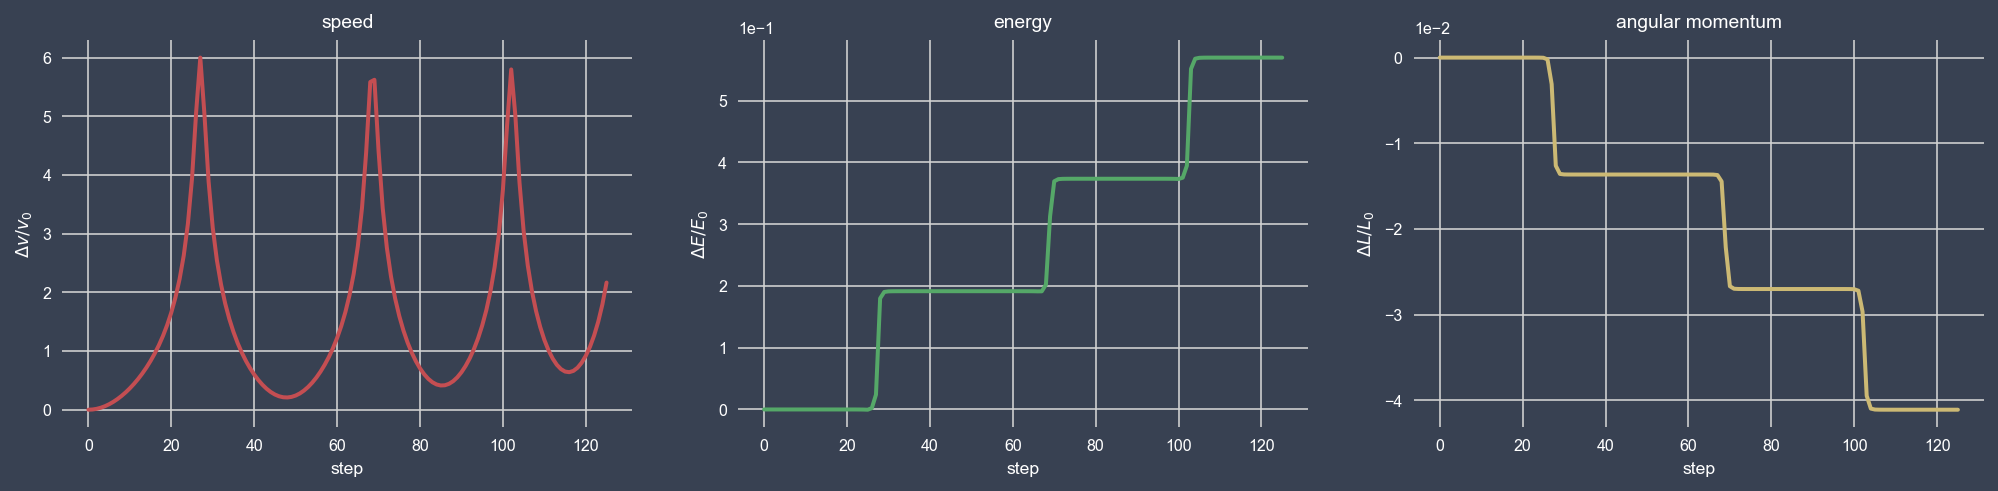

In [171]:
###############################################################
# Calculate
###############################################################

dist = np.sqrt(x**2 + y**2) # distance

speed = np.sqrt(vx**2 + vy**2) # speed
speed_0 = np.sqrt(vx[0]**2 + vy[0]**2)

spec_E = 0.5*speed**2 - G*M/dist # specific energy
spec_E0 = 0.5*speed[0]**2 - G*M/dist[0]

spec_L = []
for i in range(len(x)):
    r = np.array([x[i], y[i], 0])
    v = np.array([vx[i], vy[i], 0])
    spec_L_i = np.linalg.norm(np.cross(r, v))
    spec_L.append(spec_L_i)
r0 = np.array([x[0], y[0], 0])
v0 = np.array([vx[0], vy[0], 0])
spec_L0 = np.linalg.norm(np.cross(r0, v0))

###############################################################
# Plot
###############################################################
sns.set_context('paper')
sns.set_color_codes('deep')
fig, ax = plt.subplots(1, 3, figsize=(14,3.5))
#fig.patch.set_alpha(0)
fig.patch.set_facecolor('#384152')

# speed
ax[0].plot((speed - speed_0) / speed_0, 'r', lw=2)
ax[0].set_xlabel('step')
ax[0].set_ylabel('$\Delta v/v_0$')
ax[0].set_title('speed', color='w')

# specific energy
ax[1].plot((spec_E - spec_E0) / spec_E0, 'g', lw=2)
ax[1].set_xlabel('step')
ax[1].set_ylabel('$\Delta E/E_0$')
ax[1].set_title('energy', color='w')

# specific angular momentum
ax[2].plot((spec_L - spec_L0) / spec_L0, 'y', lw=2)
ax[2].set_xlabel('step')
ax[2].set_ylabel('$\Delta L/L_0$')
ax[2].set_title('angular momentum', color='w')

fig.tight_layout()
#fig.patch.set_alpha(0)

for a in ax: 
    a.patch.set_alpha(0)
    a.yaxis.get_major_formatter().set_powerlimits((10, 10))

# Movie Maker

We can also use the data in ``` orb.dat ``` to create an animation of the interactive plot from earlier.

In [18]:
from matplotlib import animation, rc
from IPython.display import HTML

### Low Quality Preview

In [172]:
# set up the initial plot
fig, ax = plt.subplots(2, 2, figsize=(6,6))
fig.set_facecolor("#384152")
fig.patch.set_facecolor('#384152')
for a in ax.flatten():
    a.set_facecolor("#384152")
    #a.set_alpha(0)
    a.set_xticklabels([]) # just care about qualitative plots
    a.set_yticklabels([])
    
ax[0,1].annotate('yee', xy=(0.1, 0.9), xytext=(0.1, 0.9), 
                 textcoords='axes fraction', fontsize=18, color='red')
t = ascii.read('./orb.dat') # in case it wasn't saved in the previous section
# renaming fields for convenience
n = t['n']
time = t['t (s)']
x = t['x (cm)']
y = t['y (cm)']
vx = t['vx (cm/s)']
vy = t['vy (cm/s)']

plt.close() # hide static image
lim = 2.5
ax[0,0].set_xlim(( -lim, lim))
ax[0,0].set_ylim((-lim, lim))

# set up the artists
star_color = xkcd("pinkish orange")
E_color = xkcd("robin's egg blue")
K_color = xkcd('salmon')
U_color = xkcd('yellowish')
host = plt.Circle((0, 0), 0.3, fc=star_color)
line1, = ax[0,0].plot([], [], lw=2)
line2, = ax[0,0].plot([], [], lw=2)
line3, = ax[0,0].plot([], [], lw=2)
line4, = ax[0,1].plot([], [], lw=2, c=E_color)
line5, = ax[0,1].plot([], [], lw=2)
line6, = ax[1,0].plot([], [], lw=2, c=K_color)
line7, = ax[1,0].plot([], [], lw=2)
line8, = ax[1,1].plot([], [], lw=2, c=U_color)
line9, = ax[1,1].plot([], [], lw=2)
line = [host, line1, line2, line3, line4, line5, line6, line7, line8, line9]

# initialization function: plot the background of each frame
def init():
    ax[0,0].add_patch(host)
    line[1].set_data([], []) # XY plot
    line[2].set_data([], [])
    line[3].set_data([], [])
    line[4].set_data([], []) # E plot
    line[5].set_data([], [])
    ax[0,1].annotate('total', xy=(0.1, 0.9), xycoords='axes fraction', 
                     fontsize=18, color=E_color)
    line[6].set_data([], []) # KE plot
    line[7].set_data([], [])
    ax[1,0].annotate('kinetic', xy=(0.1, 0.9), xycoords='axes fraction', 
                     fontsize=18, color=K_color)
    line[8].set_data([], []) # U plot
    line[9].set_data([], [])
    ax[1,1].annotate('potential', xy=(0.1, 0.9), xycoords='axes fraction', 
                     fontsize=18, color=U_color)
    return line

# animation function. This is called sequentially
def animate(i):
   # plot the trajectory
    line[1].set_data(x[:i+1] / au, y[:i+1] / au) 
    # the +1 makes it inclusive
    line[1].set_color('orange')
    
    # add a point at the beginning
    line[2].set_data(x[0] / au, y[0] / au)
    line[2].set_marker('X')
    line[2].set_markersize(10)
    line[2].set_color(xkcd("light lavender"))
    
    # add a point at the end
    line[3].set_data(x[i] / au, y[i] / au)
    line[3].set_marker('o')
    line[3].set_markersize(10)
    line[3].set_color(xkcd("fluorescent green"))
    
    # energy breakdown plot
    dist    = np.sqrt(x**2 + y**2) # distance
    speed   = np.sqrt(vx**2 + vy**2) # speed
    spec_K  = 0.5*speed**2
    spec_U  = -G*M / dist
    spec_E  = spec_K + spec_U
    
    # total energy
    lim_neg = np.min(spec_E/spec_E[0])
    lim_pos = np.max(spec_E/spec_E[0])
    ax[0,1].set_ylim((lim_neg, lim_pos))
    ax[0,1].set_xlim((0, len(time)))
    line[4].set_data(n, spec_E/spec_E[0])
    line[5].set_data(n[i], spec_E[i]/spec_E[0])
    line[5].set_marker('o')
    line[5].set_color(E_color)
    line[5].set_markersize(10)
    
    # kinetic energy
    lim_neg = np.min(spec_K/spec_K[0])
    lim_pos = np.max(spec_K/spec_K[0])
    ax[1,0].set_ylim((lim_neg, lim_pos))
    ax[1,0].set_xlim((0, len(time)))
    line[6].set_data(n, spec_K/spec_K[0])
    line[7].set_data(n[i], spec_K[i]/spec_K[0])
    line[7].set_marker('o')
    line[7].set_color(K_color)
    line[7].set_markersize(10)
    
    # potential energy
    lim_neg = np.min(spec_U/np.abs(spec_U[0]))
    lim_pos = np.max(spec_U/np.abs(spec_U[0]))
    ax[1,1].set_ylim((lim_neg, lim_pos))
    ax[1,1].set_xlim((0, len(time)))
    line[8].set_data(n, spec_U/np.abs(spec_U[0]))
    line[9].set_data(n[i], spec_U[i]/np.abs(spec_U[0]))
    line[9].set_marker('o')
    line[9].set_color(U_color)
    line[9].set_markersize(10)
    return line

# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
                    wspace=0.05, hspace=0.05)

N = len(x)
spf = 0.05 # seconds per frame
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N, 
                               interval=spf * 1000, blit=False)
HTML(anim.to_html5_video())

Let's dissect ```FuncAnimation``` a bit. 
* `fig`: figure object that the movie will be made on top off
* `animate`: function that updates the plot. can be controlled by iterator `i` as first argument of `animate`
* `init_func`: can be thought of as the first frame that is drawn in the movie. If omitted, the first frame drawn is just the first frame created by `animate`
* `frames`: number of still images that will be sown together by ffmpeg and interval is the delay in milliseconds before showing the next frame of the movie. Feel free to play around with both to achieve a desired frame rate
* `interval`: time in milliseconds between displaying the next frame
* `blit`: speeds up processing of the movie by only re-drawing the parts of the frame that have changed

### High Quality Movie

A higher quality mp4 can also be saved using ```FFMpegWriter```. The codec can be adjusted for compatibility on different computers.

In [173]:
# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
#                    wspace=None, hspace=None)
spf = 0.05 # seconds per frame

FFMpegWriter = animation.writers['ffmpeg']

# Change the video bitrate as you like 
mywriter = FFMpegWriter(fps=15)

anim = animation.FuncAnimation(fig, animate, frames=N, init_func=init, 
                               interval = (spf * 1000), blit=True)

anim.save("./orb.mp4", writer=mywriter, dpi=500, codec=None)